### ODL - Group 1 : Binary Classification of Detecting Hypothyroid Disease

- Foo Lee Yi - TP054547
- Gun Ming Fai - TP056531
- Khor Zhen Win - TP055619
- Woon Eusean - TP055977


In [ ]:
%pip install numpy
%pip install pandas
%pip install matplotlib
%pip install seaborn
%pip install sklearn
%pip install scipy
%pip install keras
%pip install tensorflow
%pip install keras-tuner

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

### Read Dataset


In [2]:
# set dataframe column display to show all columns
pd.set_option("display.max_columns", None)
# set dataframe row display to show all rows
pd.set_option("display.max_rows", None)

In [3]:
df1 = pd.read_csv("dataset/thyroidDF.csv")
df2 = pd.read_csv("dataset/hypothyroid.csv")

In [4]:
df1.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_meds,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,query_hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,TSH_measured,TSH,T3_measured,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source,target,patient_id
0,29,F,f,f,f,f,f,f,f,t,f,f,f,f,f,f,t,0.3,f,NaN,f,NaN,f,NaN,f,NaN,f,NaN,other,-,840801013
1,29,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,1.6,t,1.9,t,128.0,f,NaN,f,NaN,f,NaN,other,-,840801014
2,41,F,f,f,f,f,f,f,f,f,t,f,f,f,f,f,f,NaN,f,NaN,f,NaN,f,NaN,f,NaN,t,11.0,other,-,840801042
3,36,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,f,NaN,f,NaN,f,NaN,f,NaN,f,NaN,t,26.0,other,-,840803046
4,32,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,f,NaN,f,NaN,f,NaN,f,NaN,f,NaN,t,36.0,other,S,840803047


In [5]:
df2.head()

,age,sex,on thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,query hypothyroid,query hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,TSH measured,TSH,T3 measured,T3,TT4 measured,TT4,T4U measured,T4U,FTI measured,FTI,TBG measured,TBG,referral source,binaryClass
0,41,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,1.3,t,2.5,t,125,t,1.14,t,109,f,?,SVHC,P
1,23,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,4.1,t,2,t,102,f,?,f,?,f,?,other,P
2,46,M,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,0.98,f,?,t,109,t,0.91,t,120,f,?,other,P
3,70,F,t,f,f,f,f,f,f,f,f,f,f,f,f,f,t,0.16,t,1.9,t,175,f,?,f,?,f,?,other,P
4,70,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,0.72,t,1.2,t,61,t,0.87,t,70,f,?,SVI,P


### Data Preprocessing


#### Renaming Columns to Merge Dataframes


In [6]:
# normalize df2 column name to snake_case
df2.columns = df2.columns.str.replace(" ", "_")

In [7]:
# check if normalized
# print column difference of df2 and df1
print(set(df2.columns) - set(df1.columns))
print(set(df1.columns) - set(df2.columns))
print(len(set(df2.columns) - set(df1.columns)))

{'on_antithyroid_medication', 'binaryClass'}
{'on_antithyroid_meds', 'target', 'patient_id'}
2


In [8]:
# normalize on_antithyroid_medication -> on_antithyroid_meds
# drop patient_id in df1
df1.drop("patient_id", axis=1, inplace=True)
df2.rename(
    columns={"on_antithyroid_medication": "on_antithyroid_meds"}, inplace=True)

In [9]:
# number of columns in df1 and df2
print(len(df1.columns))
print(len(df2.columns))

30
30


#### Extracting Binary Target in Multi-Level Target Variable


Letter Diagnosis For Target Variable

---

"-" FOR NO CONDITION - Group 0

**hyperthyroid conditions:** - Group 1

- A: hyperthyroid
- B: T3 toxic
- C: toxic goitre
- D: secondary toxic

**hypothyroid conditions:** - Group 2

- E: hypothyroid
- F: primary hypothyroid
- G: compensated hypothyroid
- H: secondary hypothyroid

**binding protein:** - Group 3

- I: increased binding protein
- J: decreased binding protein

**general health:** - Group 4

- K: concurrent non-thyroidal illness

**replacement therapy:** - Group 5

- L: consistent with replacement therapy
- M: underreplaced
- N: overreplaced

**antithyroid treatment:** - Group 6

- O: antithyroid drugs
- P: I131 treatment
- Q: surgery

**miscellaneous:** - Group 7

- R: discordant assay results
- S: elevated TBG
- T: elevated thyroid hormones


- A diagnosis of the form "XY" is interpreted as "consistent with X, but more likely Y"
- However, for consistency in preprocessing, we will treat "XY" as "X" and classes alike


In [10]:
# grouping of target column based on grouped levels defined
# 0 - "-"
# 1 - A,B,C,D
# 2 - E,F,G,H
# 3 - I,J
# 4 - K
# 5 - L,M,N
# 6 - O,P,Q
# 7 - R,S,T


# define function to group target column
def group_target(x):
    # if x is anything but string, return 0
    if type(x) == int:
        return x
    # split x to get first character
    x = x[0]
    if x in ["A", "B", "C", "D"]:
        return 1
    elif x in ["E", "F", "G", "H"]:
        return 2
    elif x in ["I", "J"]:
        return 3
    elif x == "K":
        return 4
    elif x in ["L", "M", "N"]:
        return 5
    elif x in ["O", "P", "Q"]:
        return 6
    elif x in ["R", "S", "T"]:
        return 7
    else:
        return 0

<Axes: xlabel='target', ylabel='count'>

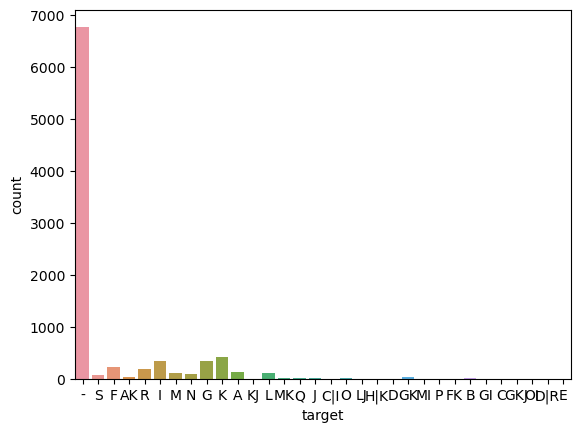

In [11]:
# plot barchart for distribution of "target" column
sns.countplot(x="target", data=df1)

In [12]:
# apply function to target column while remain int
df1["target"] = df1["target"].apply(group_target).astype("Int64")
# drop rows with "target" column having None values
df1.dropna(subset=["target"], inplace=True)
df1["target"].value_counts()

0    6771
2     667
4     447
3     376
5     355
7     281
1     241
6      34
Name: target, dtype: Int64

##### Labelling Target Variable For Second Dataset To Merge


Since this dataset is specifically for hypothyroid conditions

- "P" in the binaryClass will fall under Group 2
- "N" in the binaryClass will fall under Group 0


<Axes: xlabel='binaryClass', ylabel='count'>

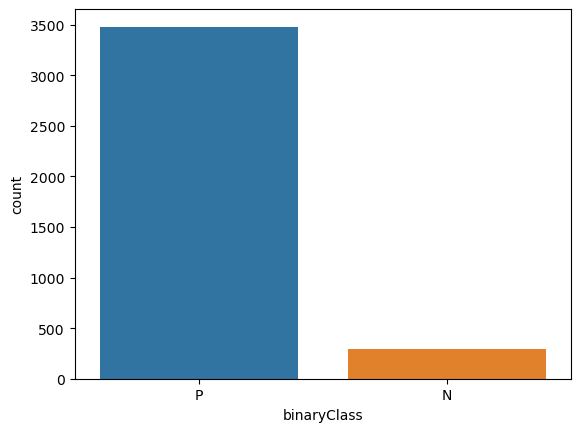

In [13]:
sns.countplot(x="binaryClass", data=df2)
# P - Positive Hypothyroid
# N - Negative Hypothyroid

In [14]:
# rename binaryClass to target and convert P to 2 and N to 0
df2.rename(columns={"binaryClass": "target"}, inplace=True)
df2["target"] = df2["target"].map({"P": 2, "N": 0})
df2["target"].value_counts()

2    3481
0     291
Name: target, dtype: int64

#### Merge Dataframes & Evaluate


In [15]:
# merge df1 and df2
df = pd.concat([df1, df2], axis=0)

In [16]:
print(df.shape)
df.head()

(12944, 30)


,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_meds,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,query_hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,TSH_measured,TSH,T3_measured,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source,target
0,29,F,f,f,f,f,f,f,f,t,f,f,f,f,f,f,t,0.3,f,NaN,f,NaN,f,NaN,f,NaN,f,NaN,other,0
1,29,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,1.6,t,1.9,t,128.0,f,NaN,f,NaN,f,NaN,other,0
2,41,F,f,f,f,f,f,f,f,f,t,f,f,f,f,f,f,NaN,f,NaN,f,NaN,f,NaN,f,NaN,t,11.0,other,0
3,36,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,f,NaN,f,NaN,f,NaN,f,NaN,f,NaN,t,26.0,other,0
4,32,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,f,NaN,f,NaN,f,NaN,f,NaN,f,NaN,t,36.0,other,7


In [17]:
# check for new target distribution
df["target"].value_counts()

0    7062
2    4148
4     447
3     376
5     355
7     281
1     241
6      34
Name: target, dtype: Int64

#### Check For Null Values


In [18]:
# check for null values in target variable
df["target"].isnull().sum()

0

In [19]:
# check for columns that contain "?" and null values
for col in df.columns:
    if df[col][df[col] == "?"].count() > 1 or df[col].isnull().sum() > 1:
        empty_rows = df[col][df[col] == "?"].count() + df[col].isnull().sum()
        print(col, empty_rows)
        # print percentage of empty_rows , round to 2 decimal place
        print(round(empty_rows / df.shape[0] * 100, 2), "%")

sex 457
3.53 %
TSH 1211
9.36 %
T3 3373
26.06 %
TT4 673
5.2 %
T4U 1196
9.24 %
FTI 1187
9.17 %
TBG 12595
97.3 %


In [20]:
# drop TBG & T3 columns
df.drop(["TBG", "T3"], axis=1, inplace=True)

#### Imputing


Columns may contain a string of "?" to signify missing values.

- Imputed with mean for float values
- Imputed with mode for categorical values


In [21]:
def replace_null(df):
    for col in df.columns:
        df[col] = df[col].replace("?", np.nan)
        if col in ["age", "TSH", "T3", "TT4", "T4U", "FTI", "TBG"]:
            df[col] = df[col].astype(float)
    return df

In [22]:
def impute_mean(df):
    for col in df.columns:
        if col in ["age", "TSH", "T3", "TT4", "T4U", "FTI", "TBG"]:
            df[col].fillna(df[col].mean(), inplace=True)
    return df

In [23]:
def impute_mode(df):
    for col in df.columns:
        if col not in ["age", "TSH", "T3", "TT4", "T4U", "FTI", "TBG"]:
            df[col].fillna(df[col].mode()[0], inplace=True)
    return df

In [24]:
df = replace_null(df)
print(df.columns)
print(len(df.columns))
print(df.shape)

Index(['age', 'sex', 'on_thyroxine', 'query_on_thyroxine',
       'on_antithyroid_meds', 'sick', 'pregnant', 'thyroid_surgery',
       'I131_treatment', 'query_hypothyroid', 'query_hyperthyroid', 'lithium',
       'goitre', 'tumor', 'hypopituitary', 'psych', 'TSH_measured', 'TSH',
       'T3_measured', 'TT4_measured', 'TT4', 'T4U_measured', 'T4U',
       'FTI_measured', 'FTI', 'TBG_measured', 'referral_source', 'target'],
      dtype='object')
28
(12944, 28)


In [25]:
# count the number of '?' in each column
for col in df.columns:
    print(col, df[col].loc[df[col] == "?"].count())

age 0
sex 0
on_thyroxine 0
query_on_thyroxine 0
on_antithyroid_meds 0
sick 0
pregnant 0
thyroid_surgery 0
I131_treatment 0
query_hypothyroid 0
query_hyperthyroid 0
lithium 0
goitre 0
tumor 0
hypopituitary 0
psych 0
TSH_measured 0
TSH 0
T3_measured 0
TT4_measured 0
TT4 0
T4U_measured 0
T4U 0
FTI_measured 0
FTI 0
TBG_measured 0
referral_source 0
target 0


#### Preprocessing Based on Data Types


##### Column Data Types


Float/Int Columns

- age, TSD, T3, TT4, T4U, FTI, TBG

Boolean Columns

- on_thyroxine, query_on_thyroxine, on_antithyroid_meds, sick, pregnant, thyroid_surgery, I131_treatment, query_hypothyroid, query_hyperthyroid, lithium, goitre, tumor, psych, TSH_measured, T3_measured, TT4_measured, T4U_measured, FTI_measured, TBG_measured

String Columns

- sex, referral_source, hypopituitary


In [26]:
# feature significance test libraries
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif

# Kruskal-Wallis Test
from scipy.stats import kruskal

##### Numerical Variables - ANOVA Test


###### EDA


In [27]:
def plot_box_hist(df):
    for col in df.columns:
        if col in ["age", "TSH", "T3", "TT4", "T4U", "FTI", "TBG"]:
            plt.figure(figsize=(10, 5))
            plt.subplot(1, 2, 1)
            sns.boxplot(x=df[col])
            plt.subplot(1, 2, 2)
            sns.histplot(df[col], kde=True)
            plt.show()

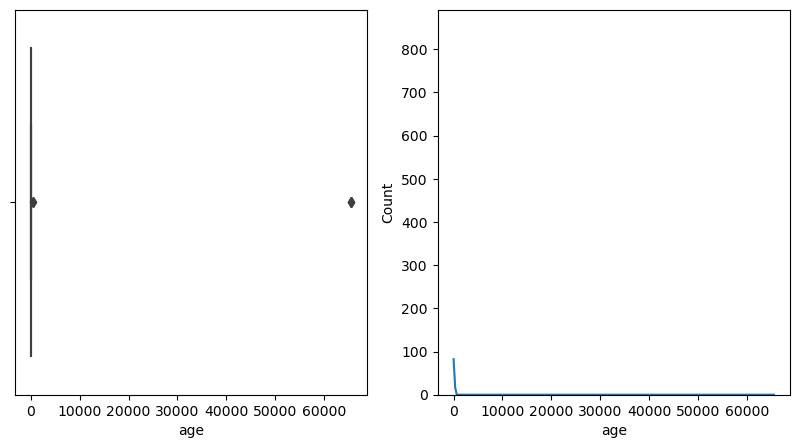

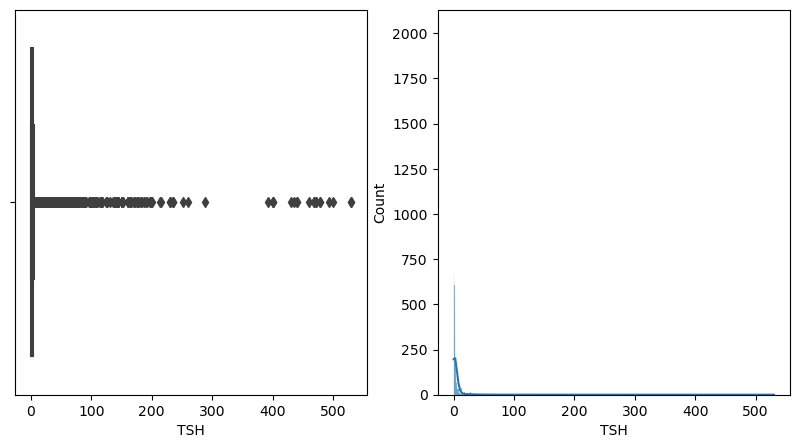

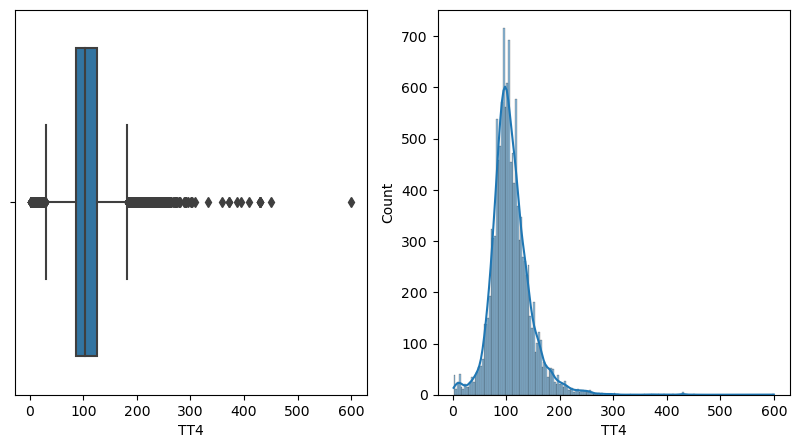

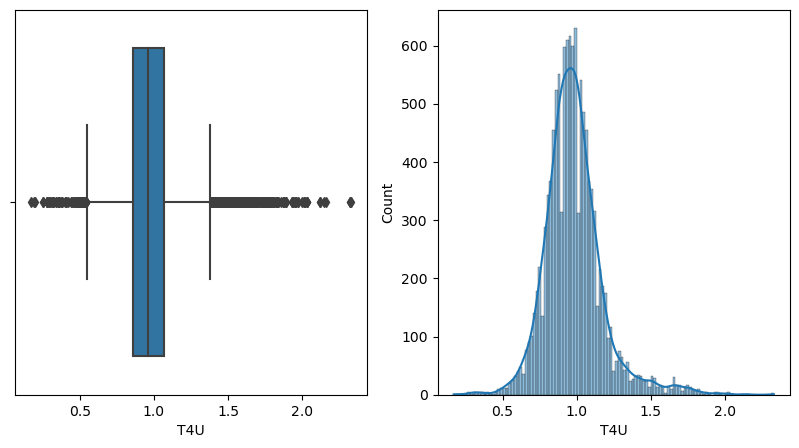

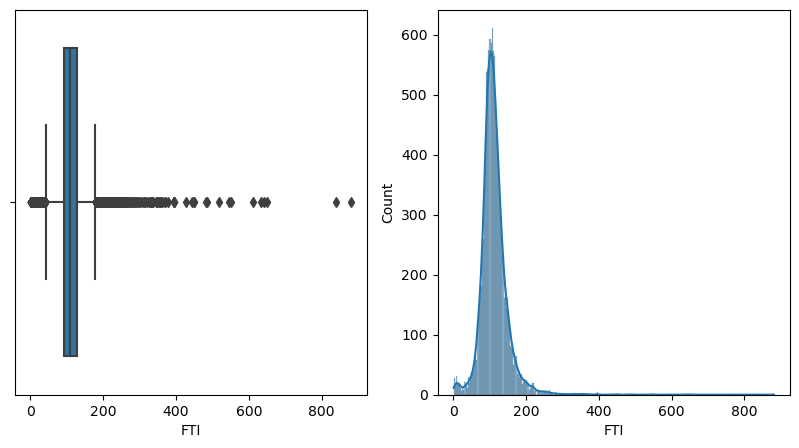

In [28]:
plot_box_hist(df)

In [29]:
# show statistical summary of float_columns
df.describe()

,age,TSH,TT4,T4U,FTI,target
count,12943.000000,11733.000000,12271.000000,11748.000000,11757.000000,12944.0
mean,67.198486,5.180223,108.590372,0.981514,112.727204,1.189663
std,996.776946,24.281392,36.978256,0.199137,39.326029,1.594759
min,1.000000,0.005000,2.000000,0.170000,1.400000,0.0
25%,37.000000,0.470000,87.000000,0.860000,93.000000,0.0
50%,55.000000,1.400000,104.000000,0.960000,108.000000,0.0
75%,67.000000,2.700000,125.000000,1.070000,127.000000,2.0
max,65526.000000,530.000000,600.000000,2.330000,881.000000,7.0


###### Preprocessing Outliers


In [30]:
# age, TSH, TT4, FTI columns have outliers that fall in illogical range
# these values were obtained through literature review + average ranges of each column (Q5)

# check for number of rows with age > 100
print("Age")
print(df["age"][df["age"] > 100].count())

# check for number of rows with TSH > 20
print("TSH")
print(df["TSH"][df["TSH"] > 20].count())

# check for number of rows with TT4 > 250
print("TT4")
print(df["TT4"][df["TT4"] > 250].count())

# check for number of rows with FTI > 250
print("FTI")
print(df["FTI"][df["FTI"] > 250].count())

Age
5
TSH
457
TT4
56
FTI
94


In [31]:
# drop rows of outliers as number of rows is insignificant

# drop rows with age > 100
df.drop(df[df["age"] > 100].index, inplace=True)

# drop rows with TSH > 20
df.drop(df[df["TSH"] > 20].index, inplace=True)

# drop rows with TT4 > 250
df.drop(df[df["TT4"] > 250].index, inplace=True)

# drop rows with FTI > 250
df.drop(df[df["FTI"] > 250].index, inplace=True)

# check number of rows after dropping outliers
print(df.shape)

(12044, 28)


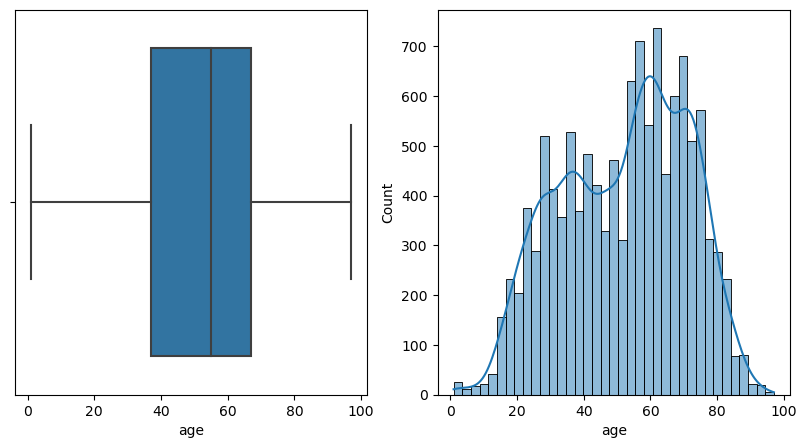

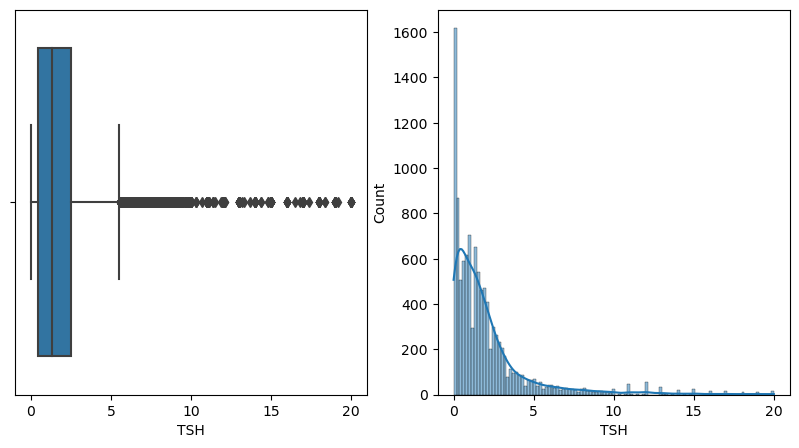

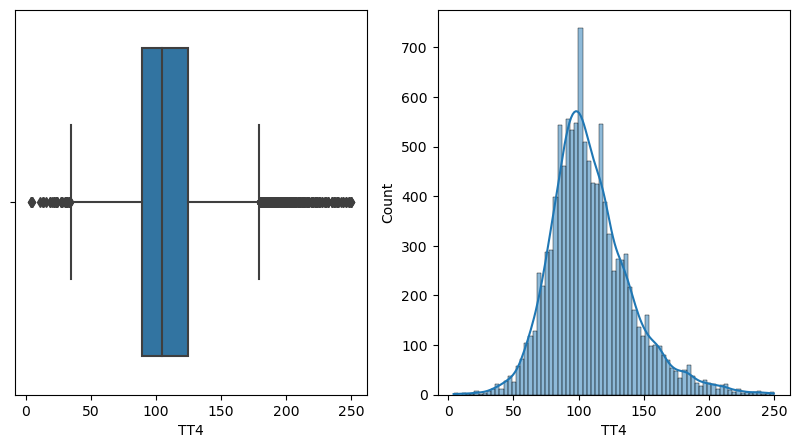

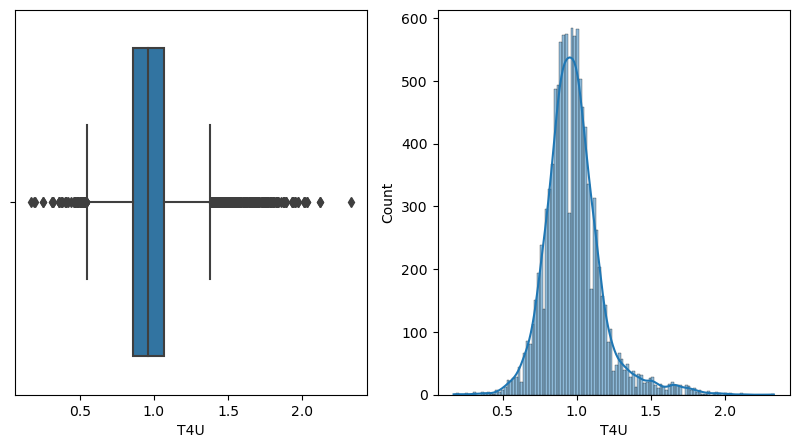

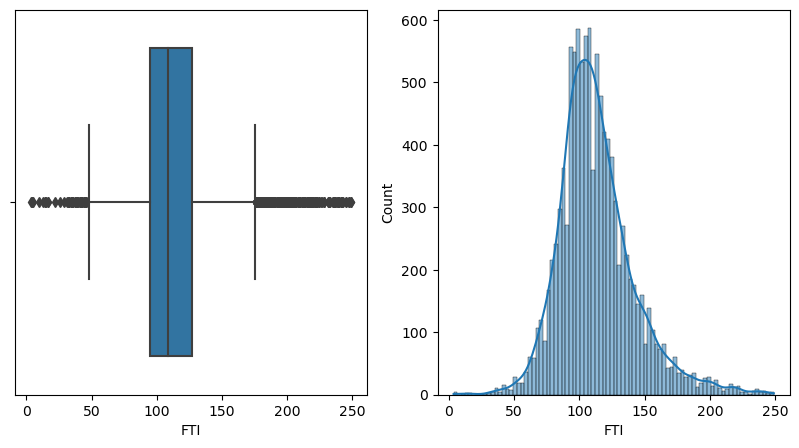

,age,TSH,TT4,T4U,FTI,target
count,12043.000000,10874.000000,11401.000000,10914.000000,10923.000000,12044.0
mean,52.017521,2.088079,109.333830,0.979240,113.098293,1.153354
std,18.915716,2.707012,31.369568,0.195181,29.137996,1.595834
min,1.000000,0.005000,4.000000,0.170000,3.500000,0.0
25%,37.000000,0.450000,89.000000,0.860000,95.000000,0.0
50%,55.000000,1.300000,105.000000,0.960000,109.000000,0.0
75%,67.000000,2.500000,125.000000,1.070000,127.000000,2.0
max,97.000000,20.000000,250.000000,2.330000,249.000000,7.0


In [32]:
# re-examine statistical summary of float_columns and check for outliers
plot_box_hist(df)
df.describe()

In [33]:
# impute the mean for the columns now after the outliers have been removed
df = impute_mean(df)

###### ANOVA Test


In [34]:
#  f_classif test on numerical columns
float_columns = df.select_dtypes(include=["float", "int"])
# drop target from float_columns
float_columns.drop("target", axis=1, inplace=True)

anova_test = SelectKBest(score_func=f_classif, k="all")
anova_test.fit(float_columns, df["target"])

# create dataframe for with colums [column_name, f_classif_score, f_classif_p_value]
anova_score = pd.DataFrame(
    {
        "column_name": float_columns.columns,
        "f_classif_score": anova_test.scores_,
        "f_classif_p_value": anova_test.pvalues_,
    },
)

# sort dataframe by f_classif_p_value in ascending order
anova_score = anova_score.sort_values(
    by="f_classif_p_value", ascending=True
).reset_index(drop=True)

# determine significant columns based on f_classif_p_value < 0.05
anova_score["Significant"] = np.where(
    anova_score["f_classif_p_value"] < 0.05, True, False
)

anova_score

,column_name,f_classif_score,f_classif_p_value,Significant
0,TT4,372.203869,0.000000e+00,True
1,T4U,303.486189,0.000000e+00,True
2,FTI,361.150870,0.000000e+00,True
3,TSH,61.917799,6.654143e-88,True
4,age,50.935181,6.059348e-72,True


##### Nominal Variables - Chi Square Test


###### EDA


In [35]:
def plot_bar(df):
    fig, axes = plt.subplots(5, 5, figsize=(30, 25))
    i = 0
    for col in df.columns:
        if col not in ["age", "TSH", "T3", "TT4", "T4U", "FTI", "TBG", "target"]:
            sns.countplot(x=col, data=df, ax=axes[i // 5, i % 5])
            i += 1
    plt.show()

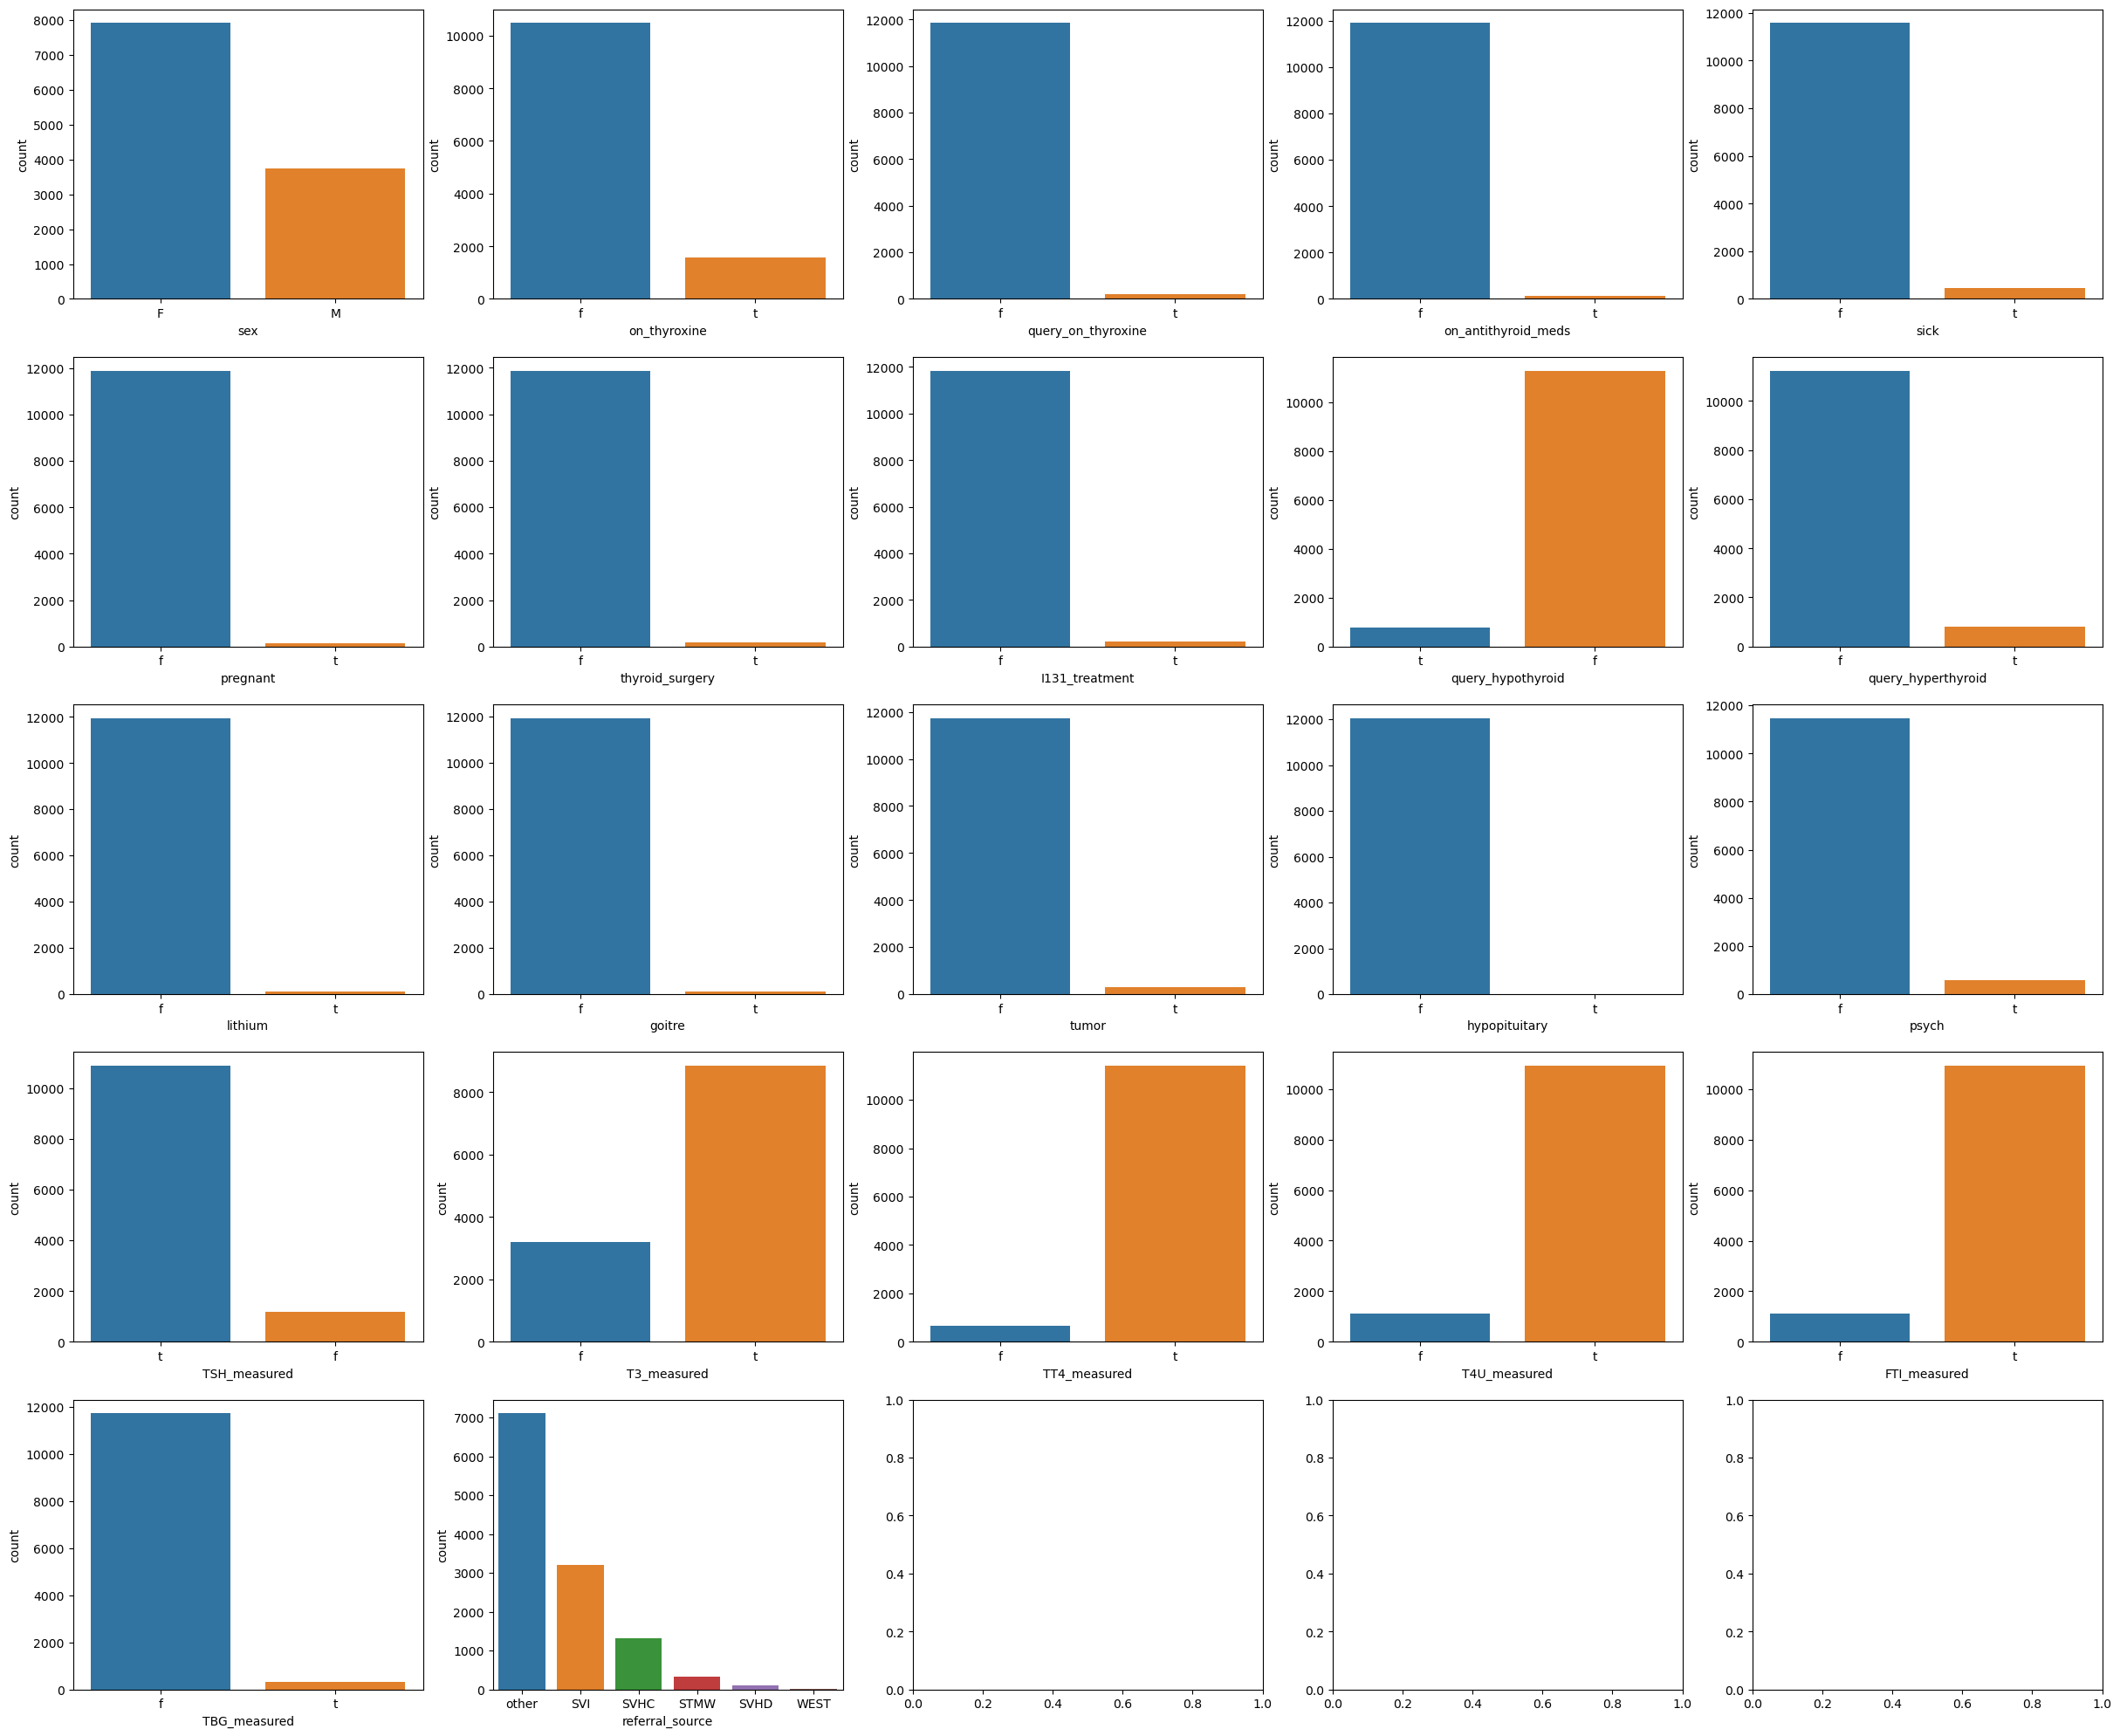

In [36]:
plot_bar(df)

###### Preprocessing Outliers


In [37]:
# impure mode for categorical columns
df = impute_mode(df)

###### Chi2 Test


In [38]:
#  chi2 test on boolean columns
from sklearn.preprocessing import LabelEncoder

nominal_columns = df.select_dtypes(include=["string", "object"])


# label encode nominal columns
le = LabelEncoder()
for col in nominal_columns.columns:
    nominal_columns[col] = le.fit_transform(nominal_columns[col])

In [39]:
#  chi2 test on binary columns
chi2_test = SelectKBest(score_func=chi2, k="all")
chi2_test.fit(nominal_columns, df["target"])

# create dataframe for with colums [column_name, chi2_score, chi2_p_value]
chi2_score = pd.DataFrame(
    {
        "column_name": nominal_columns.columns,
        "chi2_score": chi2_test.scores_,
        "chi2_p_value": chi2_test.pvalues_,
    },
)

# sort dataframe by f_classif_p_value in ascending order
chi2_score = chi2_score.sort_values(by="chi2_p_value", ascending=True).reset_index(
    drop=True
)

# determine significant columns based on f_classif_p_value < 0.05
chi2_score["Significant"] = np.where(
    chi2_score["chi2_p_value"] < 0.05, True, False)

chi2_score

,column_name,chi2_score,chi2_p_value,Significant
0,on_thyroxine,1734.701515,0.000000e+00,True
1,TBG_measured,947.522026,2.617107e-200,True
2,pregnant,768.487716,1.168911e-161,True
3,thyroid_surgery,264.794614,1.958472e-53,True
4,on_antithyroid_meds,229.098221,7.715338e-46,True
5,referral_source,193.359993,2.920348e-38,True
6,query_hyperthyroid,165.305812,2.449301e-32,True
7,sex,90.761921,8.628862e-17,True
8,T3_measured,80.970295,8.732846e-15,True
9,tumor,74.164700,2.119040e-13,True


In [40]:
# keep only significant columns
df.drop(
    [
        "goitre",
    ],
    axis=1,
    inplace=True,
)

#### Evaluate New Dataset


In [41]:
df.shape

(12044, 27)

In [42]:
df.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_meds,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,query_hyperthyroid,lithium,tumor,hypopituitary,psych,TSH_measured,TSH,T3_measured,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,referral_source,target
0,29.0,F,f,f,f,f,f,f,f,t,f,f,f,f,f,t,0.300000,f,f,109.33383,f,0.97924,f,113.098293,f,other,0
1,29.0,F,f,f,f,f,f,f,f,f,f,f,f,f,f,t,1.600000,t,t,128.00000,f,0.97924,f,113.098293,f,other,0
2,41.0,F,f,f,f,f,f,f,f,f,t,f,f,f,f,f,2.088079,f,f,109.33383,f,0.97924,f,113.098293,t,other,0
3,36.0,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,2.088079,f,f,109.33383,f,0.97924,f,113.098293,t,other,0
4,32.0,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,2.088079,f,f,109.33383,f,0.97924,f,113.098293,t,other,7


In [43]:
df.describe()

,age,TSH,TT4,T4U,FTI,target
count,12044.000000,12044.000000,12044.000000,12044.000000,12044.000000,12044.0
mean,52.017521,2.088079,109.333830,0.979240,113.098293,1.153354
std,18.914930,2.572157,30.520639,0.185798,27.748750,1.595834
min,1.000000,0.005000,4.000000,0.170000,3.500000,0.0
25%,37.000000,0.570000,90.000000,0.880000,96.000000,0.0
50%,55.000000,1.500000,107.000000,0.979240,112.000000,0.0
75%,67.000000,2.300000,124.000000,1.050000,125.000000,2.0
max,97.000000,20.000000,250.000000,2.330000,249.000000,7.0


array([[<Axes: title={'center': 'age'}>, <Axes: title={'center': 'TSH'}>],
       [<Axes: title={'center': 'TT4'}>, <Axes: title={'center': 'T4U'}>],
       [<Axes: title={'center': 'FTI'}>,
        <Axes: title={'center': 'target'}>]], dtype=object)

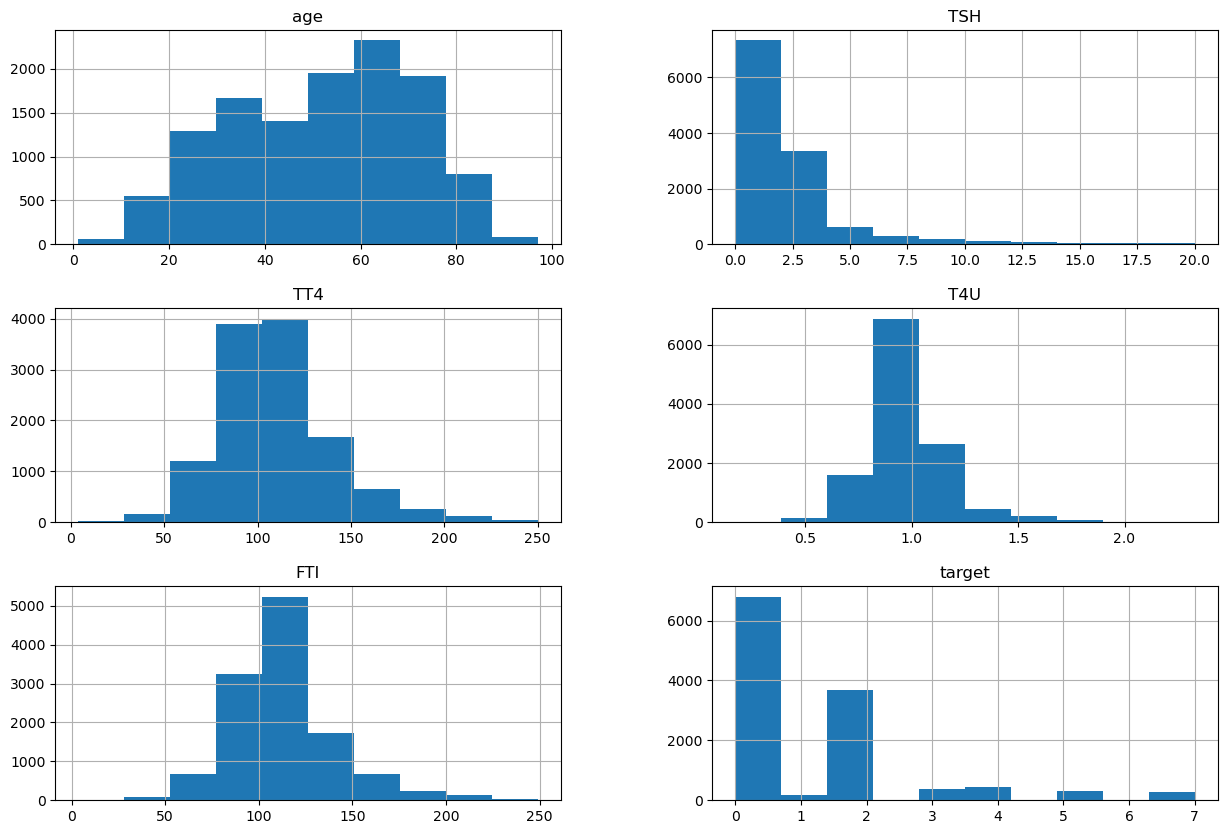

In [44]:
df.hist(bins=10, figsize=(15, 10))

### Output New Dataset


In [45]:
# output cleaned data to csv
df.to_csv("./dataset/output-multiclass-target/cleaned_data.csv", index=False)

### Split Into Train and Test Sets


In [46]:
# label encode categorical columns
from sklearn.preprocessing import LabelEncoder

df_encode = df.copy(deep=True)

le = LabelEncoder()
for col in df_encode.columns:
    if df_encode[col].dtype == "object":
        df_encode[col] = le.fit_transform(df_encode[col])

In [47]:
# split into train and test sets without splitting X and y
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_encode, test_size=0.2, random_state=42)

print("Train : " + str(train.shape))
print("Test : " + str(test.shape))

Train : (9635, 27)
Test : (2409, 27)


In [49]:
# save train_smote and test to csv
train.to_csv("./dataset/output-multiclass-target/train.csv", index=False)
test.to_csv("./dataset/output-multiclass-target/test.csv", index=False)